# 此文档用于实现更高级的网络结构
* CNN,RNN以及Transformer
## 1.CNN
* 对于卷积的理解
> 信号分析中，卷积用于求冲激响应的累计效果
> 概率论中，卷积用于求线密度（想象一下一条线平移过平面，故命名为卷积）
> 图像处理中，卷积用于求卷积算子和图像数据点积（卷积算子滑过图像的过程类似于上面线滑过平面的过程
* 1*1的卷积核主要用于将变换图像的通道数

In [33]:
import torch as T

# 1*1卷积核实现
def corr2d_one(X,K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.reshape(c_i,h*w) # 相当于Flatten
    K = K.reshape(c_o,c_i)
    Y = T.matmul(K,X)
    return Y.reshape(c_o,h,w)

X = T.normal(0,1,size=(3,3,3))
K = T.normal(0,1,size=(2,3,1,1))

print(corr2d_one(X,K))

tensor([[[-0.1143,  0.4737,  0.0367],
         [ 0.2748,  0.2931,  0.3290],
         [-0.5537,  0.4485, -0.3726]],

        [[-0.2469,  1.4514,  1.5542],
         [-0.5878,  2.3781, -1.9455],
         [ 0.7309,  2.8021, -3.5875]]])


* Lenet实现

In [2]:
import torch as T
import torchvision as tv
import torch.nn as nn
import torch.nn.init as init

from torch.utils import data
from torchvision import transforms

# 检查是否有可用的 GPU
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

# 定义数据生成器
def load_data(batch_size):
    # 将图像从 PIL 格式或 NumPy 数组转换为 PyTorch 的张量（tensor）
    trans = [transforms.ToTensor()]
    # 是一个用于将多个转换操作组合在一起的工具
    trans = transforms.Compose(trans)
    # 加载mnist数据集
    train_data = tv.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
    test_data = tv.datasets.MNIST(root='./data', train=False, download=True, transform=trans)
    # 定义数据加载器
    train_iter = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_iter = data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_iter, test_iter

# 定义网络并移动到 GPU
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=(5,5),padding=(2,2)),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
    nn.Conv2d(6,16,kernel_size=(5,5)),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.ReLU(),
    nn.Linear(120,84),
    nn.ReLU(),
    nn.Linear(84,10)
).to(device)

# 初始化函数
def initialize_weights(model):
    for layer in model:
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # 使用 He 初始化
            if layer.bias is not None:
                init.zeros_(layer.bias)  # 偏置初始化为 0

# 调用初始化函数
initialize_weights(net)

# 损失函数
loss = nn.CrossEntropyLoss()

# 优化器
sgd = T.optim.SGD(net.parameters(), lr=0.1)

# 训练
epoch = 10
batch_size = 256
train_iter, test_iter = load_data(batch_size)
for i in range(epoch):
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)  # 将数据移动到 GPU
        sgd.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        sgd.step()
    
    # 测试阶段
    net.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    test_loss = 0.0

    with T.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            test_loss += loss(y_hat, y).item()  # 累加测试损失
            predicted = T.argmax(y_hat, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f"Epoch: {i + 1}, Loss: {test_loss / len(test_iter):.4f}, Test Accuracy: {accuracy:.4f}")


Epoch: 1, Loss: 0.2811, Test Accuracy: 0.9085
Epoch: 2, Loss: 0.1123, Test Accuracy: 0.9652
Epoch: 3, Loss: 0.0916, Test Accuracy: 0.9696
Epoch: 4, Loss: 0.1141, Test Accuracy: 0.9646
Epoch: 5, Loss: 0.0652, Test Accuracy: 0.9786
Epoch: 6, Loss: 0.0629, Test Accuracy: 0.9782
Epoch: 7, Loss: 0.0601, Test Accuracy: 0.9797
Epoch: 8, Loss: 0.0713, Test Accuracy: 0.9762
Epoch: 9, Loss: 0.0641, Test Accuracy: 0.9790
Epoch: 10, Loss: 0.0481, Test Accuracy: 0.9850


* 2012年AlexNet横空出世
> 下面展示如何将图片的像素大小从28 * 28调整为224 * 224（底层原理是插值法）

In [2]:
from torch.utils import data
from torchvision import transforms
import torchvision as tv

# 定义数据生成器
def load_data(batch_size,resize):
    trans = [transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]  # 将图像转换为张量,并归一化
    if resize:
        trans.insert(0,transforms.Resize(resize)) # 增广
    trans = transforms.Compose(trans) # 拼接所有操作
    # 加载mnist数据集
    train_data = tv.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
    test_data = tv.datasets.MNIST(root='./data', train=False, download=True, transform=trans)
    # 定义数据加载器
    train_iter = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_iter = data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_iter, test_iter

#train_iter, test_iter = load_data(128,224)
#for X, y in train_iter:
    #print(X.shape)
    #break

> AlexNet的结构(自定义实现)
> 等同于：
```python
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 10),
)
```

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # 卷积层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)

        # 最大池化层
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # 全连接层
        self.fc1 = nn.Linear(6400, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # 卷积层 + ReLU + 最大池化
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        # 展平
        x = x.view(x.size(0), -1)  # 将多维输入展平为一维
        
        # 全连接层 + ReLU
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)  # dropout
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)  # dropout
        x = self.fc3(x)  # 输出层

        return x

> 初始化函数

In [4]:
import torch.nn.init as init

# 初始化函数
def initialize_weights(model):
    for layer in model.children(): # 这里因为net使用Class创建，所以使用children()，而使用sequential创建的模型可以直接遍历
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # 使用 He 初始化
            if layer.bias is not None:
                init.zeros_(layer.bias)  # 偏置初始化为 0
        elif isinstance(layer, nn.BatchNorm2d):
            init.ones_(layer.weight)  # 批归一化层的权重初始化为 1
            init.zeros_(layer.bias)  # 偏置初始化为 0

net = AlexNet()
initialize_weights(net)
# 打印模型的所有参数
#for name, param in net.named_parameters():
    #print(name, param.shape)
#print([layer for layer in net.children()])


* 训练

In [7]:
import torch as T
# 训练
epoch = 10
batch_size = 256
# 损失函数
loss = nn.CrossEntropyLoss()
# 优化器
optimizer = T.optim.SGD(net.parameters(), lr=0.01)

# 检查是否有可用的 GPU
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
net.to(device)

train_iter, test_iter = load_data(batch_size,224)

for i in range(epoch):
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)  # 将数据移动到 GPU
        optimizer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
    
    # 测试阶段
    net.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    test_loss = 0.0

    with T.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            test_loss += loss(y_hat, y).item()  # 累加测试损失
            predicted = T.argmax(y_hat, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f"Epoch: {i + 1}, Loss: {test_loss / len(test_iter):.4f}, Test Accuracy: {accuracy:.4f}")

Epoch: 1, Loss: 0.0303, Test Accuracy: 0.9899
Epoch: 2, Loss: 0.0258, Test Accuracy: 0.9909
Epoch: 3, Loss: 0.0215, Test Accuracy: 0.9930
Epoch: 4, Loss: 0.0328, Test Accuracy: 0.9887
Epoch: 5, Loss: 0.0284, Test Accuracy: 0.9910
Epoch: 6, Loss: 0.0235, Test Accuracy: 0.9929
Epoch: 7, Loss: 0.0217, Test Accuracy: 0.9932
Epoch: 8, Loss: 0.0229, Test Accuracy: 0.9918
Epoch: 9, Loss: 0.0210, Test Accuracy: 0.9932
Epoch: 10, Loss: 0.0238, Test Accuracy: 0.9928


* 批量规范化
> 训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手
> 批量规范化使得研究人员能够训练100层以上的网络

* 在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，我们应用比例系数和比例偏移。请注意，如果我们尝试使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。这是因为在减去均值之后，每个隐藏单元将为0。所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。

减少过拟合：在某种程度上，批量规范化有助于正则化效果，减少模型的过拟合。

允许更深的网络：使得训练非常深的网络变得可行，因为它缓解了梯度消失或爆炸的问题

In [1]:
import torch as T
from torch import nn

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps=1e-5,momentum=0.9):
    if not T.is_grad_enabled():  # 测试时使用
        X_hat = (X - moving_mean) / T.sqrt(moving_var + eps)
    else:  # 训练时使用
        assert len(X.shape) in (2, 4), "Input must be 2D or 4D tensor"
        if len(X.shape) == 2:  # 2D tensor
            mean = X.mean(dim=0, keepdim=True)
            var = X.var(dim=0, keepdim=True)
        else:  # 4D tensor
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = X.var(dim=(0, 2, 3), keepdim=True)
        # 标准化
        X_hat = (X - mean) / T.sqrt(var + eps)
        # 更新移动平均，为了可以在测试时使用
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims,eps=1e-5, momentum=0.9):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
            # 2D tensor通常用于全连接层的输入
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)
            # 4D tensor通常用于卷积层的输出
        else:
            raise ValueError("num_dims must be either 2 or 4")
        # 初始化gamma和beta参数
        self.gamma = nn.Parameter(T.ones(shape))
        self.beta = nn.Parameter(T.zeros(shape))
        # 初始化移动平均和方差
        self.moving_mean = T.zeros(shape)
        self.moving_var = T.ones(shape)
        # 其他参数
        self.eps = eps
        self.momentum = momentum
    def forward(self, X):
        if self.moving_mean.device != X.device:
            # 确保移动平均和方差在同一设备上
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 调用batch_norm函数进行批归一化    
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            self.eps, self.momentum)
        return Y

* Resnet（残差网）

In [4]:
import torch as T
from torch import nn
from torch.nn import functional as F

class resnet_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(resnet_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = BatchNorm(out_channels, num_dims=4)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = BatchNorm(out_channels, num_dims=4)
        self.stride = stride

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [ ]:
blk = resnet_block(3, 3)
X = T.rand(4, 3, 6, 6)  
Y = blk(X)
print(Y.shape) # 输出形状应为 (4, 3, 6, 6)

torch.Size([4, 3, 6, 6])


* 下载Resnet-152看着玩玩

In [8]:
import torch
import torchvision.models as models
import os

# 设置自定义缓存目录
custom_cache_dir = './model'
os.makedirs(custom_cache_dir, exist_ok=True)
os.environ['TORCH_HOME'] = custom_cache_dir

# 加载预训练的 ResNet-152 模型
resnet152 = models.resnet152(pretrained=True)

# 保存模型
model_path = os.path.join(custom_cache_dir, 'resnet152.pth')
torch.save(resnet152.state_dict(), model_path)

# 将模型设置为评估模式
resnet152.eval()

# 模拟一个输入图像，形状为 (batch_size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224)

# 使用模型进行推理
with torch.no_grad():
    output = resnet152(input_tensor)

print("Output shape:", output.shape)  # 输出: torch.Size([1, 1000])，对应 1000 类的预测


Output shape: torch.Size([1, 1000])


## 2.RNN
* MLP处理矩阵表格数据，CNN处理图像数据，现在到了序列数据
### 2.1 数据集处理

* 首先需要处理文本数据预处理

In [2]:
from d2l import torch as d2l
import re
import os
import collections

# 创建data目录（如果不存在）
data_dir = './data/TimeMachine'
os.makedirs(data_dir, exist_ok=True)

# 定义数据集的URL和校验和
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    # 指定下载到./data目录
    data_file = d2l.download('time_machine', cache_dir=data_dir)
    
    with open(data_file, 'r') as f:
        lines = f.readlines()
    # 处理每一行，去除非字母字符并转换为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(f'数据集位置: {os.path.abspath(data_dir)}/timemachine.txt')
print(lines[0])
print(lines[10])


# 文本总行数: 3221
数据集位置: d:\XB-library\Summer\Deep_Learning\data\TimeMachine/timemachine.txt
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


* 词元化，将文本列表拆分成词元

In [3]:
def tokenize(lines, token='word'):
    """将文本行列表拆分成词元"""
    if token == 'word':
        # 使用正则表达式将每行拆分成单词
        tokens = [line.split() for line in lines]
    elif token == 'char':
        # 将每行转换为字符列表
        tokens = [list(line) for line in lines]
    else:
        raise ValueError("token must be either 'word' or 'char'")
    return tokens

tokens = tokenize(lines, 'char')
print(tokens[0])  # 输出第一行的词元列表

tokens = tokenize(lines, 'word')
print(tokens[0])  # 输出第一行的词元列表

['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'b', 'y', ' ', 'h', ' ', 'g', ' ', 'w', 'e', 'l', 'l', 's']
['the', 'time', 'machine', 'by', 'h', 'g', 'wells']


* 词元的类型是字符串，而模型需要输入数字，所以需要构建词表

In [4]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 单个词元或词元列表转换为索引
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        # 如果是列表或元组，则递归返回对应的索引列表
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

这里记录一些深度学习之外的python类使用方法
```python
    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
```
把一个方法“包装”成属性访问的形式,而不需要加括号 vocab.token_freqs()，也不允许做赋值 vocab.token_freqs = …（只读）

```python
def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
```
重载了 Python 的 “方括号” 操作（也就是 __getitem__ 方法），所以当你写idx = vocab[tokens[i]]时，Python 会去调用vocab.__getitem__(tokens[i])

In [43]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10]) # 这是一个字典，包含词元及其索引
print(vocab.idx_to_token[:10])  # 这是一个列表，包含索引对应的词元
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
['<unk>', 'the', 'i', 'and', 'of', 'a', 'to', 'was', 'in', 'that']
文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


* 整合所有功能

In [5]:
def load_time_machine(max_tokens=-1):  #@save
    """加载时间机器数据集"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0: 
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_time_machine()
print(f'语料库长度: {len(corpus)}')
print(f'词表大小: {len(vocab)}') # 26个英文字母和空格以及unk


语料库长度: 170580
词表大小: 28


* 下面处理数据集

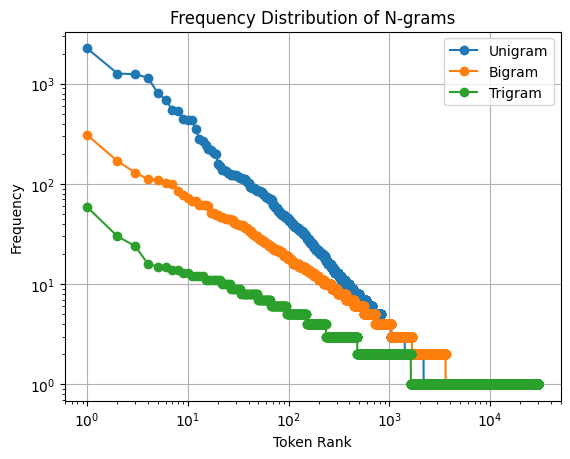

In [6]:
import torch as T
from d2l import torch as d2l
import random
import matplotlib.pyplot as plt

# 一元语法
corpus = tokenize(read_time_machine(), 'word')
# 将每行的词元展平为一个列表
corpus = [token for line in corpus for token in line]  # 展平列表
vocab = Vocab(corpus)
frequcy = [freq for token, freq in vocab.token_freqs]

# 二元语法
two_corpus = [pair for pair in zip(corpus[:-1], corpus[1:])]
two_vocab = Vocab(two_corpus)
two_freq = [freq for token, freq in two_vocab.token_freqs]

# 三元语法
three_corpus = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
three_vocab = Vocab(three_corpus)
three_freq = [freq for token, freq in three_vocab.token_freqs]

# 绘制图形
plt.figure()

# 对数坐标系
plt.loglog(range(1, len(frequcy) + 1), frequcy, label='Unigram', marker='o')
plt.loglog(range(1, len(two_freq) + 1), two_freq, label='Bigram', marker='o')
plt.loglog(range(1, len(three_freq) + 1), three_freq, label='Trigram', marker='o')

# 添加标签和图例
plt.xlabel('Token Rank')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of N-grams')
plt.legend()
plt.grid(True)
# plt.show()

上图可以看出除了一元语法词，单词序列似乎也遵循齐普夫定律；词表中n元组的数量并没有那么大，这说明语言中存在相当多的结构，这些结构给了我们应用模型的希望。

* 读取长序列数据

* 随机采样

In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """随机采样数据迭代器"""
    corpus = corpus[random.randint(0,num_steps-1):]  # 随机采样起始位置
    num_subseqs = (len(corpus) - 1) // num_steps # 计算子序列的数量
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))  # 计算初始索引
    random.shuffle(initial_indices)  # 打乱初始索引
    
    def data(pos):
        """返回从pos开始的长度为num_steps的子序列"""
        return corpus[pos: pos + num_steps]
    num_batches = num_subseqs // batch_size  # 计算批次数量
    
    for i in range(0, num_batches * batch_size, batch_size):
        initial_indices_batch = initial_indices[i:i + batch_size]
        X = T.tensor([data(pos) for pos in initial_indices_batch])
        Y = T.tensor([data(pos + 1) for pos in initial_indices_batch])
        yield X, Y

* 顺序分区：在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。

* 将随机采样和顺序分区包装成一个类

In [1]:
from d2l import torch as d2l
import re
import os
import collections

# 定义数据集的URL和校验和
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
data_dir = './data/TimeMachine'

# 下载并创建数据目录
def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    # 指定下载到./data目录
    data_file = d2l.download('time_machine', cache_dir=data_dir)
    
    with open(data_file, 'r') as f:
        lines = f.readlines()
    # 处理每一行，去除非字母字符并转换为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# 词元化
def tokenize(lines, token='word'):
    """将文本行列表拆分成词元"""
    if token == 'word':
        # 使用正则表达式将每行拆分成单词
        tokens = [line.split() for line in lines]
    elif token == 'char':
        # 将每行转换为字符列表
        tokens = [list(line) for line in lines]
    else:
        raise ValueError("token must be either 'word' or 'char'")
    return tokens

# 构建词表
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 单个词元或词元列表转换为索引
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        # 如果是列表或元组，则递归返回对应的索引列表
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

# 加载时间机器数据集，返回值为语料库和词表
def load_time_machine(max_tokens=-1):  #@save
    """加载时间机器数据集"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0: 
        corpus = corpus[:max_tokens]
    return corpus, vocab

# 数据迭代器
class seqDataLoader:
    """顺序分区和随机采样的序列数据加载器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        self.batch_size = batch_size
        self.num_steps = num_steps
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = load_time_machine(max_tokens) 
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

# 加载时间机器数据集，返回值为数据迭代器和词表
def load_data_time_machine(batch_size, num_steps, use_random_iter=True, max_tokens=-1):
    """加载时间机器数据集"""
    data_iter = seqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter,data_iter.vocab

### 2.2.RNN网络的实现

In [15]:
import math
import torch as T
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps,
                                           use_random_iter=False, max_tokens=10000)

print(f'词表大小: {len(vocab)}')

词表大小: 28


* 独热向量，将词元的编号转化为独热向量，更具表现力

In [11]:
F.one_hot(T.tensor([0, 1, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

* 初始化模型参数

注意这里for X in inputs按照时间步长进行遍历，这也体现出了RNN的一个问题，不能并行处理长序列数据，后续的注意力机制可以解决这个问题。

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    """初始化模型参数"""
    num_inputs = num_outputs = vocab_size
    # 初始化权重
    def normal(shape):
        return T.normal(0, 0.01, size=shape, device=device)
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = T.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = T.zeros(num_outputs, device=device)
    
    paras = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in paras:
        param.requires_grad = True  # 设置参数可训练
    return paras

# 定义RNN模型
def rnn(inputs, state, params):
    """RNN模型"""
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 初始化输出列表
    outputs = []
    # inputs是一个形状为(时间步数, 批量大小, 词表大小)的张量 
    for X in inputs:# X大小为(批量大小, 词表大小)，state大小为(批量大小, 隐藏层大小)
        # 计算隐藏状态
        state = T.tanh(T.matmul(X, W_xh) + T.matmul(state, W_hh) + b_h)
        # 计算输出
        Y = T.matmul(state, W_hq) + b_q
        outputs.append(Y)
    return T.cat(outputs,dim=0), state  # 返回输出和最后的隐藏状态

def init_rnn_state(batch_size, num_hiddens, device):
    """初始化RNN的隐藏状态"""
    return (T.zeros((batch_size, num_hiddens), device=device))

* 定义一个类包装这些函数

__call__使一个类能像函数一样被使用

__iter__和 __next__一起使用，用于实现迭代器协议的两个特殊方法，它们使得对象可以被迭代

__getitem__支持索引操作（obj[key]）。

In [49]:
class RNNmodel:
    def __init__(self, vocab_size, num_hiddens, device,get_params,init_state,forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn
    def __call__(self, inputs, state):
        """调用模型"""
        # 转为独热向量
        inputs = F.one_hot(inputs.T, self.vocab_size).type(T.float32)
        return self.forward_fn(inputs, state, self.params)  
    def begin_state(self, batch_size, device):
        """初始化隐藏状态"""    
        return self.init_state(batch_size, self.num_hiddens, device)

num_hiddens = 512
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
net = RNNmodel(len(vocab), num_hiddens, device,
               get_params, init_rnn_state, rnn)
X = T.arange(10).reshape((2, 5))
state = net.begin_state(X.shape[0], device)
Y, state = net(X.to(device), state)
print(Y.shape)  # 输出形状应为 (10, vocab_size)
print(state.shape)  # 输出形状应为 (2, num_hiddens)


torch.Size([10, 28])
torch.Size([2, 512])


* 预测函数

首先应该进行预热，即根据当前输入的字符串计算出所有隐状态，完成后再预测num_preds个时间步

In [7]:
def predict_rnn(prefix, num_preds, net, vocab, device):
    """使用RNN模型进行预测"""
    state = net.begin_state(1, device)  # 初始化隐藏状态
    outputs = [vocab[prefix[0]]]  # 将前缀的第一个字符转换为索引
    get_input = lambda: T.tensor([outputs[-1]], device=device).reshape((1, 1))  # 获取下一个输入
    # 预热期
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])  # 将前缀的下一个字符转换为
    # 预测num_preds个字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join(vocab.to_tokens(outputs))  # 将索引转换为字符并返回字符串

predict_rnn('time traveller', 10, net, vocab, device)

'time travellerukyxt<unk>sjws'

可以看到没训练的预测乱七八糟

* 梯度裁剪

长度为T的序列在反向传播的过程中会产生很长的乘法链条，极容易产生梯度爆炸或梯度消失，所以应该进行梯度裁剪

In [8]:
def grad_clipping(net, theta):
    """梯度裁剪"""
    if isinstance(net, RNNmodel):
        params = net.params
    else:
        params = [p for p in net.parameters() if p.requires_grad]
    norm = T.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm  # 按比例缩放梯度

* 训练

这里注意顺序分区和随机分区训练的不同：

顺序分区当前小批量数据最后一个样本的隐状态，将用于初始化下一个小批量数据第一个样本的隐状态，存储在隐状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。但这样做会使梯度计算变得复杂，需要在每一个小批量数据处理前分离梯度。

随即分区需要为每个迭代周期重新初始化隐状态。

* 一个epoch内的操作

这里state.detach_()的操作非常关键，因为参数是循环利用的，多次迭代会使得梯度完全没法计算

In [ ]:
def train_epoch(net, train_iter, loss, updater, device,use_random_iter):
    """训练一个迭代周期"""
    state = None
    s1 = 0
    s2 = 0
    for X, Y in train_iter:
        if state is None or use_random_iter:  # 第一次迭代或使用随机迭代器
            state = net.begin_state(X.shape[0], device)  # 初始化状态
        else:
            # 分离状态，避免梯度传播到之前的迭代。
            state.detach_()  
                
        y = Y.T.reshape((-1)) # 将标签展平，全是操作，为了可以计算交叉熵
        
        X, y = X.to(device), y.to(device)  # 将数据移动到设备
        y_hat, state = net(X, state)  # 前向传播
        l = loss(y_hat, y.long()).mean()  # 计算损失
        
        if isinstance(updater, T.optim.Optimizer):
            updater.zero_grad()  # 清除梯度
            l.backward()  # 反向传播
            grad_clipping(net, 1)  # 梯度裁剪
            updater.step()  # 更新参数
        else:
            l.backward()
            grad_clipping(net, 1)  # 梯度裁剪
            updater(batch_size=1)  # 更新参数
        s1 += l.item() * y.numel()
        s2 += y.numel()  # 累计预测数量
    return math.exp(s1 / s2)

* 封装好的训练过程

In [73]:
def train_rnn(net, train_iter, vocab, lr, num_epochs, device,use_random_iter=False):
    """训练RNN模型"""
    loss = nn.CrossEntropyLoss()  # 定义损失函数
    if isinstance(net, nn.Module):
        updater = T.optim.SGD(net.parameters(), lr=lr)  # 使用SGD优化器
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)  # 如果net不是nn.Module，则使用自定义的更新函数
    
    predict = lambda prefix: predict_rnn(prefix, 50, net, vocab, device)  # 定义预测函数
    
    epoch_losses = []    # 存放每个 epoch 的 loss
    
    for epoch in range(num_epochs):
        l = train_epoch(net, train_iter, loss, updater, device,use_random_iter)
        epoch_losses.append(l)
        if (epoch + 1) % 20 == 0:
            print("epoch:", epoch + 1, "loss:", l)
            
     # 训练完毕后画图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()
    # 做预测
    print(predict('time traveller'))

epoch: 20 loss: 10.629591247555252
epoch: 40 loss: 9.075417787529432
epoch: 60 loss: 8.280432305481586
epoch: 80 loss: 7.8548784731505865
epoch: 100 loss: 7.268331976177367
epoch: 120 loss: 6.867725497856982
epoch: 140 loss: 6.479563605809037
epoch: 160 loss: 5.405289703903042
epoch: 180 loss: 4.2158338779464675
epoch: 200 loss: 3.0752140216731467
epoch: 220 loss: 2.257105047569695
epoch: 240 loss: 1.7707366637877506
epoch: 260 loss: 1.52832821067231
epoch: 280 loss: 1.3672917070197415
epoch: 300 loss: 1.2928358141874816
epoch: 320 loss: 1.1202362572461968
epoch: 340 loss: 1.0647380403837945
epoch: 360 loss: 1.0434773759574134
epoch: 380 loss: 1.1523194029986727
epoch: 400 loss: 1.0554123724402968
epoch: 420 loss: 1.0535920084821837
epoch: 440 loss: 1.0361850003053026
epoch: 460 loss: 1.0269437235776597
epoch: 480 loss: 1.0442914408486708
epoch: 500 loss: 1.188558642162393


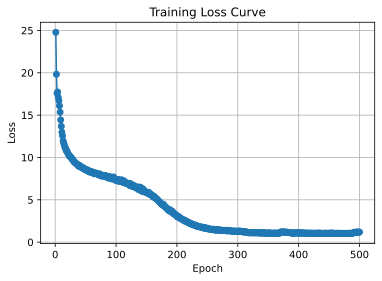

time traveller but now you begin to seethe object of my investig


In [77]:
import matplotlib.pyplot as plt

batch_size, num_steps = 32, 35
num_hiddens = 512
train_iter, vocab = load_data_time_machine(batch_size, num_steps,
                                           use_random_iter=False, max_tokens=10000)
num_epochs, lr = 500, 1
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

net = RNNmodel(len(vocab), num_hiddens, device,
               get_params, init_rnn_state, rnn)

train_rnn(net, train_iter, vocab, lr, num_epochs, device)

* 使用api的简洁实现版本,直接给出所有代码,几乎完全不依赖d2l

epoch: 50 loss: 7.4263335491908355
epoch: 100 loss: 4.979623096675342
epoch: 150 loss: 1.8004674059326313
epoch: 200 loss: 1.275113677208744
epoch: 250 loss: 1.1191818482181926
epoch: 300 loss: 1.0571047864020982
epoch: 350 loss: 1.180953350749449
epoch: 400 loss: 1.108819356611443
epoch: 450 loss: 1.0530911409736068
epoch: 500 loss: 1.0288867787101625


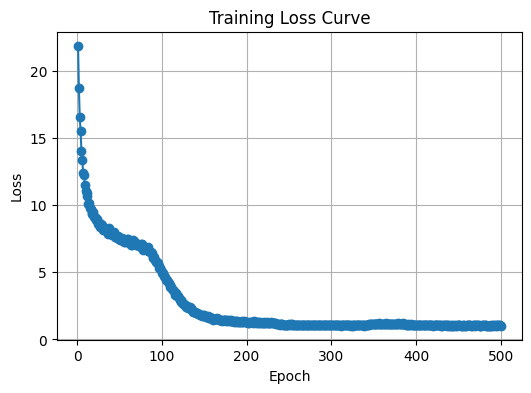

time traveller after the pauserequired for the proper assimilati


In [10]:
import torch as T
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import math

batch_size, num_steps = 32, 35
use_random_iter = False  # 使用顺序迭代器
train_iter, vocab = load_data_time_machine(batch_size, num_steps,
                                           use_random_iter, max_tokens=10000)

num_hiddens = 512
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

rnn_layer = nn.RNN(len(vocab),num_hiddens,num_layers=1)  

class RNNmodel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNmodel, self).__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = rnn_layer.hidden_size    
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T, self.vocab_size).type(T.float32)  # 转为独热向量
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))  # 展平
        return output, state
    
    def begin_state(self,batch_size, device):
        """初始化RNN的隐藏状态"""
        return T.zeros((self.rnn.num_layers,batch_size, num_hiddens), device=device)
    
def grad_clipping(net, theta):
    """梯度裁剪"""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = T.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm  # 按比例缩放梯度
            
def train_epoch(net, train_iter, loss, updater, device,use_random_iter):
    """训练一个迭代周期"""
    state = None
    s1 = 0
    s2 = 0
    for X, Y in train_iter:
        if state is None or use_random_iter:  # 第一次迭代或使用随机迭代器
            state = net.begin_state(X.shape[0], device)  # 初始化状态
        else:
            # 分离状态，避免梯度传播到之前的迭代。
            state.detach_()  
                
        y = Y.T.reshape((-1)) # 将标签展平，全是操作，为了可以计算交叉熵
        
        X, y = X.to(device), y.to(device)  # 将数据移动到设备
        y_hat, state = net(X, state)  # 前向传播
        l = loss(y_hat, y.long()).mean()  # 计算损失
        
        updater.zero_grad()  # 清除梯度
        l.backward()  # 反向传播
        grad_clipping(net, 1)  # 梯度裁剪
        updater.step()  # 更新参数

        s1 += l.item() * y.numel()
        s2 += y.numel()  # 累计预测数量
    return math.exp(s1 / s2)
           
def predict_rnn(prefix, num_preds, net, vocab, device):
    """使用RNN模型进行预测"""
    state = net.begin_state(1, device)  # 初始化隐藏状态
    outputs = [vocab[prefix[0]]]  # 将前缀的第一个字符转换为索引
    get_input = lambda: T.tensor([outputs[-1]], device=device).reshape((1, 1))  # 获取下一个输入
    # 预热期
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])  # 将前缀的下一个字符转换为
    # 预测num_preds个字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join(vocab.to_tokens(outputs))  # 将索引转换为字符并返回字符串

def train_rnn(net, train_iter, vocab, lr, num_epochs, device,use_random_iter):
    """训练RNN模型"""
    loss = nn.CrossEntropyLoss()  # 定义损失函数
    updater = T.optim.SGD(net.parameters(), lr=lr)  # 使用SGD优化器
    
    predict = lambda prefix: predict_rnn(prefix, 50, net, vocab, device)  # 定义预测函数
    
    epoch_losses = []    # 存放每个 epoch 的 loss
    
    for epoch in range(num_epochs):
        l = train_epoch(net, train_iter, loss, updater, device,use_random_iter)
        epoch_losses.append(l)
        if (epoch + 1) % 50 == 0:
            print("epoch:", epoch + 1, "loss:", l)
            
     # 训练完毕后画图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()
    # 做预测
    print(predict('time traveller'))

net = RNNmodel(rnn_layer, len(vocab))
net.to(device)  # 将模型移动到设备
num_epochs, lr = 500, 1
train_rnn(net, train_iter, vocab, lr, num_epochs, device,use_random_iter)
